In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import norm
import statsmodels.api as sm
import re
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

import copy

%matplotlib inline
%load_ext autotime

time: 172 µs (started: 2022-11-02 13:34:11 -04:00)


In [2]:
# Enrollment numbers
# https://infohub.nyced.org/reports/school-quality/information-and-data-overview
enrollment_count = {
    2017: 1135334,
    2018: 1126501,
    2019: 1131868,
    2020: 1094138,
    2021: 1058888,
    2022: 1030000 #This is an estimate that should be filled in.
}

time: 380 µs (started: 2022-11-02 13:34:11 -04:00)


In [3]:
pull_from_api = False
if (pull_from_api):
    data_orig = pd.read_json("https://data.cityofnewyork.us/resource/ez4e-fazm.json?$limit=99999999")
    data_orig['occurred_on'] = pd.to_datetime(data_orig['occurred_on'])
else:
    data_orig = pd.read_csv("../data/input/raw/Bus_Breakdown_and_Delays.csv", parse_dates = [7])

/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_51965/3086854128.py:6: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_orig = pd.read_csv("../data/input/raw/Bus_Breakdown_and_Delays.csv", parse_dates = [7])


time: 23.5 s (started: 2022-11-02 13:34:11 -04:00)


In [4]:
def clean_delay_times_old(x):
    
    if  not any(i.isdigit for i in x): # Filter trivial cases with no numbers.
        return np.nan
    
    if ('h' in x) or ('H' in x):
        return 60.0
    
    nondigits = []
    
    for i in x:
        if not i.isdigit():
            nondigits.append(i)

    for i in nondigits:
        x = x.replace(i, ',')
    
    x = x.split(',')

    for i in x:
        if len(i) > 0 and int(i) < 300.:
            return int(i)
        else:
            return np.nan

time: 789 µs (started: 2022-11-02 13:34:34 -04:00)


In [5]:
def clean_delay_times(x):
    a = x
    x = str(x).lower().rstrip().replace('1 1/2', '1 2').replace('11/2', '1 2').\
    replace('1/2', '0 1').replace('half', '0 1').replace('to', '-')
    units = re.findall(r'[a-z ]+', x)
    time = re.split(r'[- /,]', ''.join(re.findall(r'[0-9 .,/-]+', x)) )
    time = [i for i in time if not((re.search('[.]+',i) !=None)|(re.search('[ ]+',i) !=None)|(i==''))]
    if time:
        time = np.nanmean([float(i) for i in time])
    else:
        time = 0
    
    if any(i in ''.join(units) for i in ['h', 'r']) and ( time <= 5 ):
#         print(a)
#         print(time*60)
        return time*60
    elif any(i in ''.join(units) for i in ['m', 'n']) | (x == ''):
        return time
    else:
#         print(a)
#         print(time, units)
        return 0

time: 1.1 ms (started: 2022-11-02 13:34:34 -04:00)


In [6]:
# Drop the 2020 data point
# data_orig.drop(data_orig[data_orig['School_Year'] == '2019-2020'].index, inplace = True)
data_orig['delay_time'] = data_orig.How_Long_Delayed.astype(str).apply(clean_delay_times)
# Only can normalize from 2017 forth.
data_orig = data_orig[data_orig['Occurred_On'] > pd.to_datetime('08-31-2017')]

time: 21.5 s (started: 2022-11-02 13:34:34 -04:00)


In [7]:
data = copy.deepcopy(data_orig)

time: 44.9 ms (started: 2022-11-02 13:34:56 -04:00)


In [8]:
def school_year(year, month):
    if month < 9:
        return year - 1
    else: 
        return year

time: 411 µs (started: 2022-11-02 13:34:56 -04:00)


In [9]:
num_delays_threshold = 200

data_monthly = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).count()
data_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
data_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
days_per_month = data_monthly.groupby(level = ['Year', 'Month']).count()[['School_Year']]
data_monthly = data_monthly.groupby(level = ['Year', 'Month']).sum()[['School_Year']]
data_monthly['days_per_month'] = days_per_month
data_monthly['schl_yr'] = [school_year(i, j) for i, j in zip(data_monthly.index.get_level_values(0), 
                                                             data_monthly.index.get_level_values(1))]
# multiply delay frequency by enrollment count in 2022/enrollment count in respective year to normalize for changing school population
data_monthly['School_Year'] = data_monthly['School_Year']*enrollment_count[2022]/data_monthly['schl_yr'].apply(lambda x: enrollment_count[x])

#### Remove days that are not expected to be school days (below delay threshold) from data ####


data_heavy_traffic = data[data.Reason == 'Heavy Traffic']
data_accident = data[data.Reason == 'Accident']
data_problematic = data[data.Reason == 'Problem Run']
data_preventable_delay = data[(data.Reason == 'Mechanical Problem') | (data.Reason == 'Won`t Start') |
                             (data.Reason == 'Flat Tire')]# Call these "Automotive" not "Preventable Delays"

heavy_traffic_monthly = data_heavy_traffic.groupby([data_heavy_traffic['Occurred_On'].dt.year, data_heavy_traffic['Occurred_On'].dt.month, data_heavy_traffic['Occurred_On'].dt.day])[['School_Year']].count()
heavy_traffic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
heavy_traffic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
heavy_traffic_monthly = heavy_traffic_monthly.groupby(level = ['Year', 'Month']).sum()

preventable_delay_monthly = data_preventable_delay.groupby([data_preventable_delay['Occurred_On'].dt.year, data_preventable_delay['Occurred_On'].dt.month, data_preventable_delay['Occurred_On'].dt.day])[['School_Year']].count()
preventable_delay_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
preventable_delay_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
preventable_delay_monthly = preventable_delay_monthly.groupby(level = ['Year', 'Month']).sum()

accidents_monthly = data_accident.groupby([data_accident['Occurred_On'].dt.year, data_accident['Occurred_On'].dt.month, data_accident['Occurred_On'].dt.day])[['School_Year']].count()
accidents_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
accidents_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
accidents_monthly = accidents_monthly.groupby(level = ['Year', 'Month']).sum()

problematic_monthly = data_problematic.groupby([data_problematic['Occurred_On'].dt.year, data_problematic['Occurred_On'].dt.month, data_problematic['Occurred_On'].dt.day])[['School_Year']].count()
problematic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
problematic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
problematic_monthly = problematic_monthly.groupby(level = ['Year', 'Month']).sum()

data_monthly['labels'] = data_monthly.index.map(lambda x: str(calendar.month_abbr[x[1]]) + " " + str(x[0]) )
data_monthly['heavy_traffic'] = heavy_traffic_monthly['School_Year']
data_monthly['preventable_delay'] = preventable_delay_monthly['School_Year']
data_monthly['accident'] = accidents_monthly['School_Year']
data_monthly['problematic'] = problematic_monthly['School_Year']
# display(data_monthly)


# Getting number of days since Sep 1, 2015
data_monthly['date_time'] = data_monthly.index.map(lambda x: (pd.datetime(x[0], x[1], 1) 
        - pd.datetime(data_monthly.index[0][0], data_monthly.index[0][1], 1)).days )

# Drop nan days_per_month
data_monthly.dropna(inplace = True)

# Get normalized delay frequency
data_monthly['normalized_delay_frequency'] = data_monthly['School_Year']/data_monthly['days_per_month']
data_monthly['normalized_heavy_traffic'] = data_monthly['heavy_traffic']/data_monthly['days_per_month']
data_monthly['normalized_preventable_delay'] = data_monthly['preventable_delay']/data_monthly['days_per_month']
data_monthly['normalized_accident'] = data_monthly['accident']/data_monthly['days_per_month']
data_monthly['normalized_problematic'] = data_monthly['problematic']/data_monthly['days_per_month']

# Change column name
data_monthly.rename(columns = {'School_Year': 'delay_frequency'}, inplace = True)

# Make labels and ticks for plotting
ticks = copy.deepcopy(data_monthly['date_time'])
labels = copy.deepcopy(data_monthly['labels'])

time: 1.13 s (started: 2022-11-02 13:34:56 -04:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_51965/3438425519.py:53: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data_monthly['date_time'] = data_monthly.index.map(lambda x: (pd.datetime(x[0], x[1], 1)
/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_51965/3438425519.py:54: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  - pd.datetime(data_monthly.index[0][0], data_monthly.index[0][1], 1)).days )


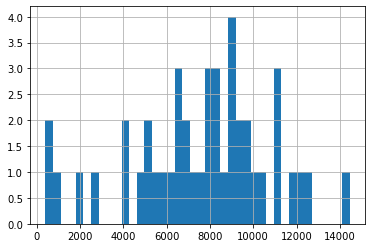

time: 270 ms (started: 2022-11-02 13:34:57 -04:00)


In [10]:
data_monthly['delay_frequency'].hist(bins = 40)

In [11]:
alpha = 1

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_heavy_traffic']).reshape(-1, 1)

from sklearn.linear_model import LinearRegression, Ridge, Lasso

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_heavy'] = lrm.predict(X_train)

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_preventable_delay']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_preventable'] = lrm.predict(X_train)

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_accident']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_accident'] = lrm.predict(X_train)


X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_problematic']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_problematic'] = lrm.predict(X_train)

time: 137 ms (started: 2022-11-02 13:34:57 -04:00)


Text(0, 0.5, 'Average number of delays per day')

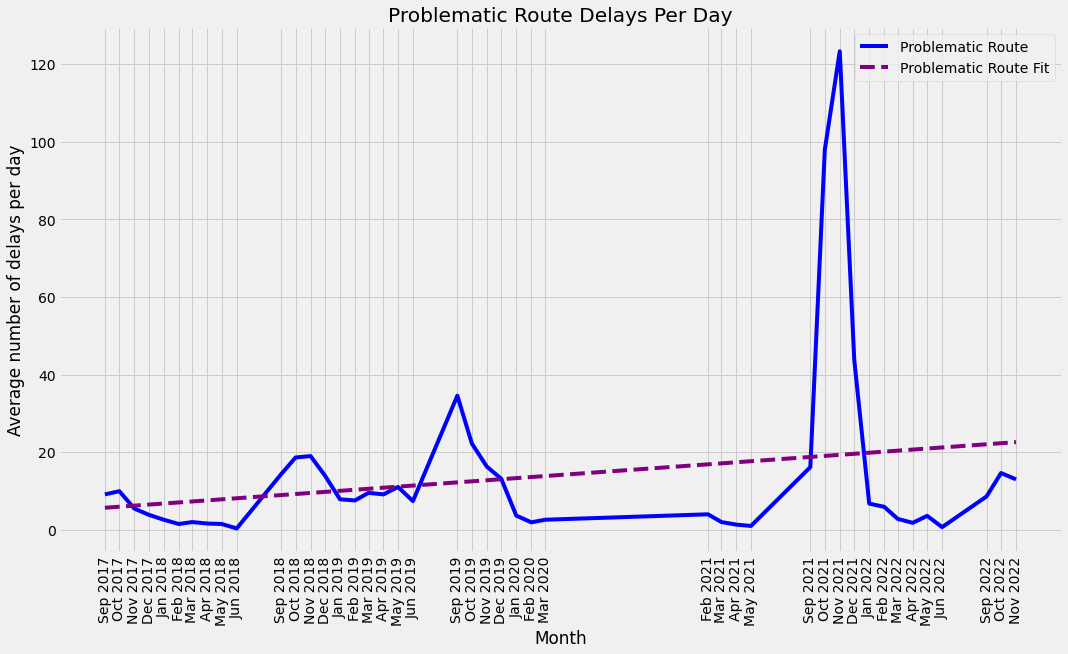

time: 412 ms (started: 2022-11-02 13:34:57 -04:00)


In [12]:
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.plot(data_monthly['date_time'], data_monthly['normalized_problematic'], label = 'Problematic Route', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_problematic'], label = 'Problematic Route Fit', linestyle = '--', color = 'purple')

# plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'] + data_monthly['normalized_heavy_traffic'].std(), label = "", linestyle = ':', color = 'purple')
# plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'] - data_monthly['normalized_heavy_traffic'].std(), label = "", linestyle = ':', color = 'purple')

# plt.plot(data_monthly['date_time'], data_monthly['normalized_preventable_delay'], label = 'Preventable* Delays', color = 'r')
# plt.plot(data_monthly['date_time'], regression_fit_preventable, label = 'Preventable Delay Fit ± std', linestyle = '--', color = 'pink')
# plt.plot(data_monthly['date_time'], regression_fit_preventable + data_monthly['normalized_preventable_delay'].std(), linestyle = ':', color = 'pink')
# plt.plot(data_monthly['date_time'], regression_fit_preventable - data_monthly['normalized_preventable_delay'].std(), linestyle = ':', color = 'pink')
# plt.plot(preventable_delay_monthly['Month'] , preventable_delay_monthly['School_Year'], label = 'All Delays')


plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Problematic Route Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0, 0.5, 'Average number of delays per day')

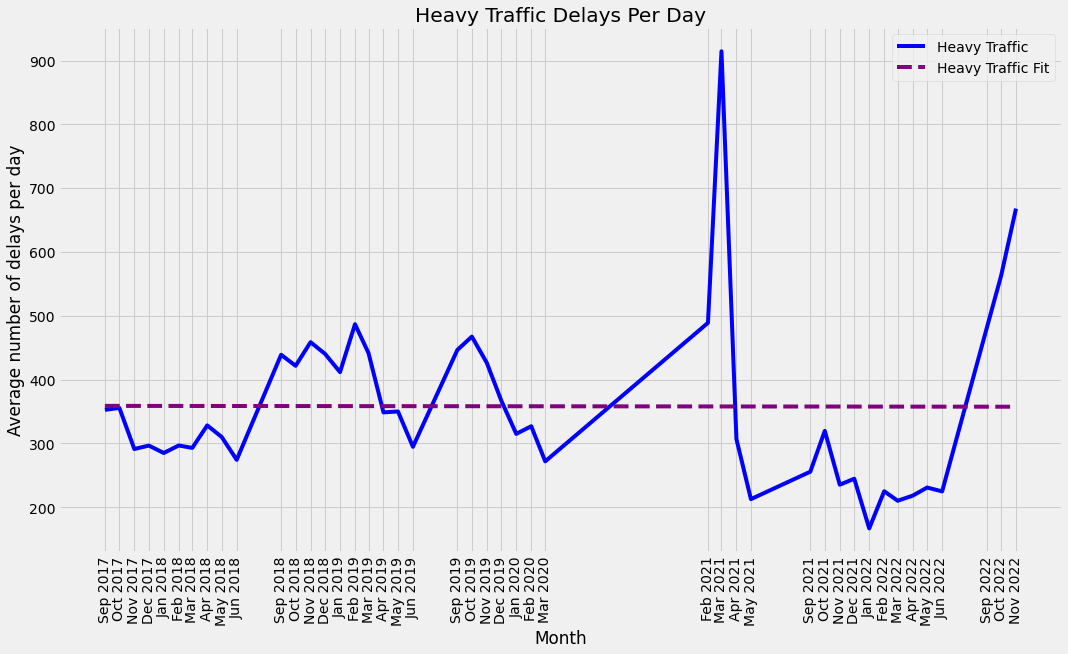

time: 380 ms (started: 2022-11-02 13:34:58 -04:00)


In [13]:
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.plot(data_monthly['date_time'], data_monthly['normalized_heavy_traffic'], label = 'Heavy Traffic', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'], label = 'Heavy Traffic Fit', linestyle = '--', color = 'purple')


plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Heavy Traffic Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0, 0.5, 'Average number of delays per day')

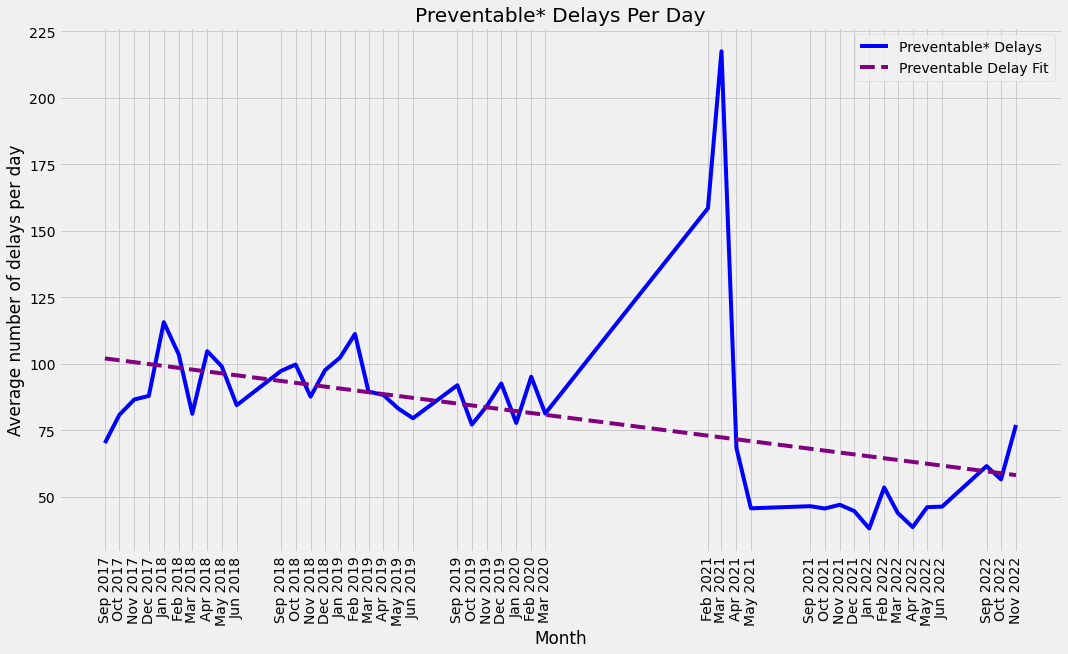

time: 354 ms (started: 2022-11-02 13:34:58 -04:00)


In [14]:
plt.plot(data_monthly['date_time'], data_monthly['normalized_preventable_delay'], label = 'Preventable* Delays', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_preventable'], label = 'Preventable Delay Fit', linestyle = '--', color = 'purple')

plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Preventable* Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0, 0.5, 'Average number of accidents per day')

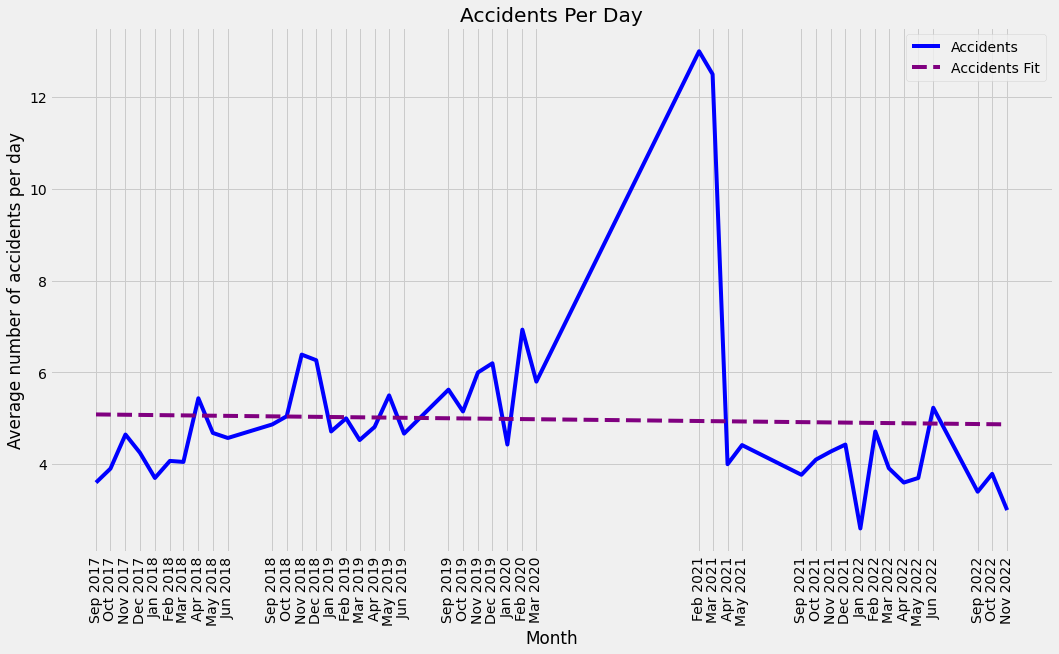

time: 549 ms (started: 2022-11-02 13:34:59 -04:00)


In [15]:
plt.plot(data_monthly['date_time'], data_monthly['normalized_accident'], label = 'Accidents', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_accident'], label = 'Accidents Fit', linestyle = '--', color = 'purple')

plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Accidents Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of accidents per day")

In [16]:
data_g = data
data_g['Heavy_Traffic'] = [(x == 'Heavy Traffic') for x in data_g['Reason']]

data_g = data.groupby(['Boro', 'Reason']).count()
data_g = data_g[['School_Year']]
data_g.rename(columns = {'School_Year':'Number_delays'}, inplace = True)
data_g.drop('All Boroughs', level = 'Boro', inplace = True)

total = np.array(data_g.merge(data_g.groupby(level = 'Boro').sum()[['Number_delays']], on = 'Boro')['Number_delays_y'])
data_g['total'] = total

data_g['Percent'] = 100*data_g['Number_delays'].astype(float)/data_g['total'].astype(float)

data_g.drop(columns = 'total', inplace = True)

data_g.to_csv("reason_for_delay_by_borough.csv")

time: 759 ms (started: 2022-11-02 13:34:59 -04:00)


In [17]:
# Quick code to find out whether traffic delays are heavier in one borough vs another.
# Look at ratio of heavy traffic delays to non heavy traffic delays by borough.

data_g = data
data_g['Heavy_Traffic'] = [(x == 'Heavy Traffic') for x in data_g['Reason']]

data_g = data.groupby(['Boro', 'Reason']).count()
data_g = data_g[['School_Year']]
data_g.rename(columns = {'School_Year':'Number_delays'}, inplace = True)
data_g.drop('All Boroughs', level = 'Boro').to_csv("reason_for_delay_by_borough.csv")
# For a given Boro, divide the School_Year associated with Heavy_Traffic == True by the false.

time: 889 ms (started: 2022-11-02 13:35:00 -04:00)


In [18]:
# Look at delays by runtype and delay type.

df = pd.DataFrame()
for i in data['Run_Type'].unique():
    new_df = pd.DataFrame(data[data['Run_Type'] == i]['Reason'].value_counts()*100/len(data[data['Run_Type'] == i]))
    new_df['Run_Type'] = i
    new_df['Number_delays'] = data[data['Run_Type'] == i]['Reason'].value_counts()
    df = pd.concat([df, new_df])
#     print (i, "\n", data[data['Run_Type'] == i]['Reason'].value_counts()/len(data[data['Run_Type'] == i]), "\n")

df.rename(columns = {'Reason': 'Percent_delay'}, inplace = True)
# df
df.to_csv("delay_by_runtype_and_delaytype.csv")

time: 997 ms (started: 2022-11-02 13:35:01 -04:00)


######################################################################################################

New Analysis for 2022

######################################################################################################

In [22]:
# Sept-Oct 2022 delays /total /average daily /average duration

#Need to say that we are only counting school days.

sept_oct_2022_total_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
print(sept_oct_2022_total_delays)


# Average daily delays

sept_oct_2022_average_daily_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
print(sept_oct_2022_average_daily_delays)

# Average duration

data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).agg(['count', 'sum'])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
data_tmp.drop(data_tmp[data_tmp['School_Year']['count'] < num_delays_threshold].index, axis = 0, inplace = True)
data_tmp=data_tmp[(data_tmp.index.get_level_values(0) == 2022 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2022_average_delay_duration = data_tmp['delay_time']['sum'].sum()/data_tmp['delay_time']['count'].sum()

print(sept_oct_2022_average_delay_duration)

23964.0
704.8235294117648
39.521407110666
time: 1.73 s (started: 2022-11-02 13:35:02 -04:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_51965/846534604.py:22: FutureWarning: ['Occurred_On', 'Incident_Number'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,


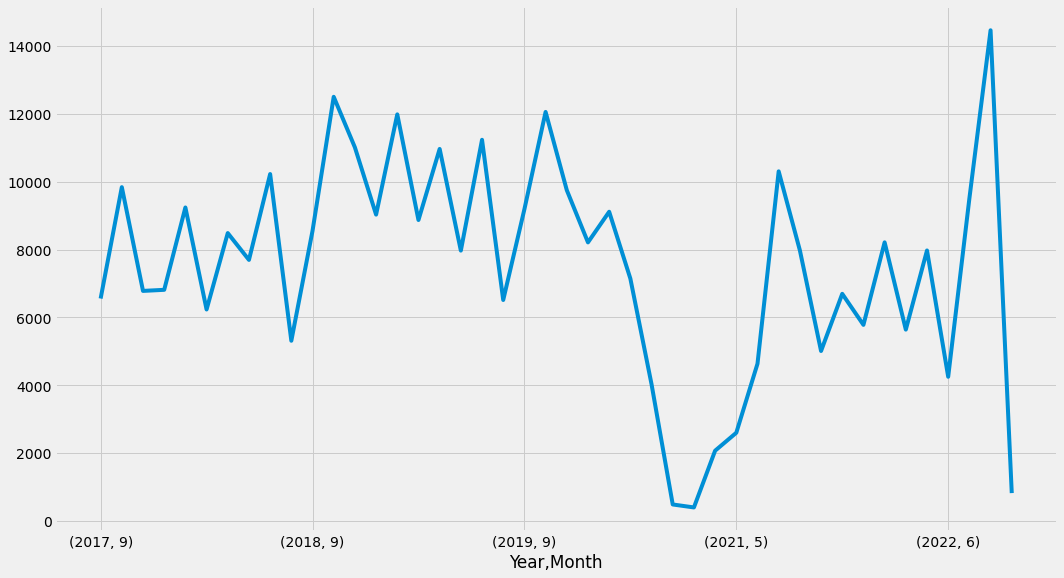

time: 143 ms (started: 2022-11-02 13:39:48 -04:00)


In [23]:
# Average delays per month chart

data_monthly['delay_frequency'].plot()

/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_51965/3305322785.py:3: FutureWarning: ['Occurred_On', 'Incident_Number'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,


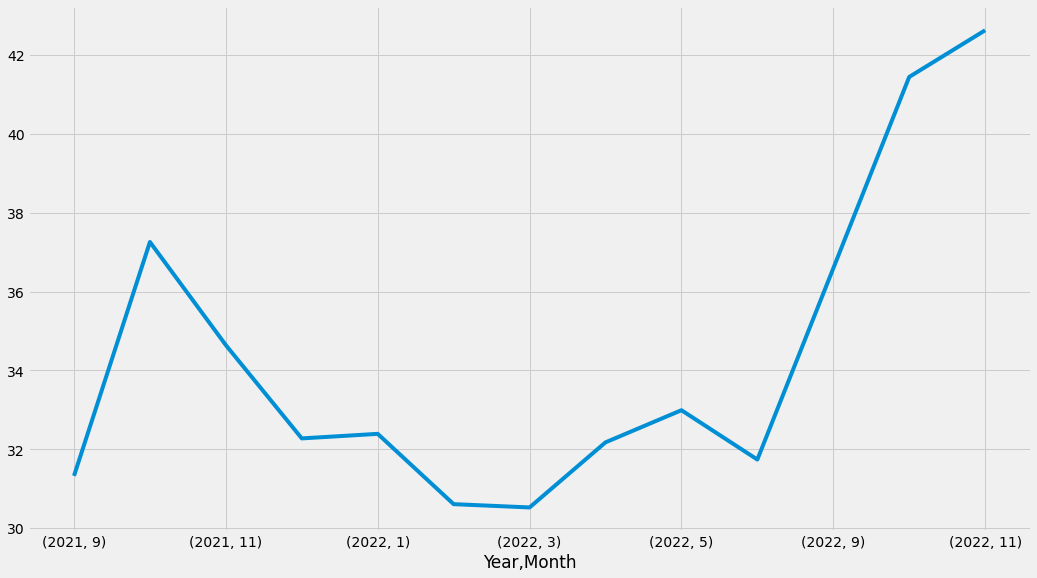

time: 1.92 s (started: 2022-11-02 15:20:21 -04:00)


In [85]:
# Average delay times per month

data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).agg(['count', 'sum'])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
data_tmp.drop(data_tmp[data_tmp['School_Year']['count'] < num_delays_threshold].index, axis = 0, inplace = True)
data_tmp = data_tmp['delay_time'].reset_index().groupby(['Year', 'Month']).sum()

# Make data_tmp post covid
data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2021)]
data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2022) |
                    (data_tmp.index.get_level_values(1) > 8)]

(data_tmp['sum']/data_tmp['count']).plot()

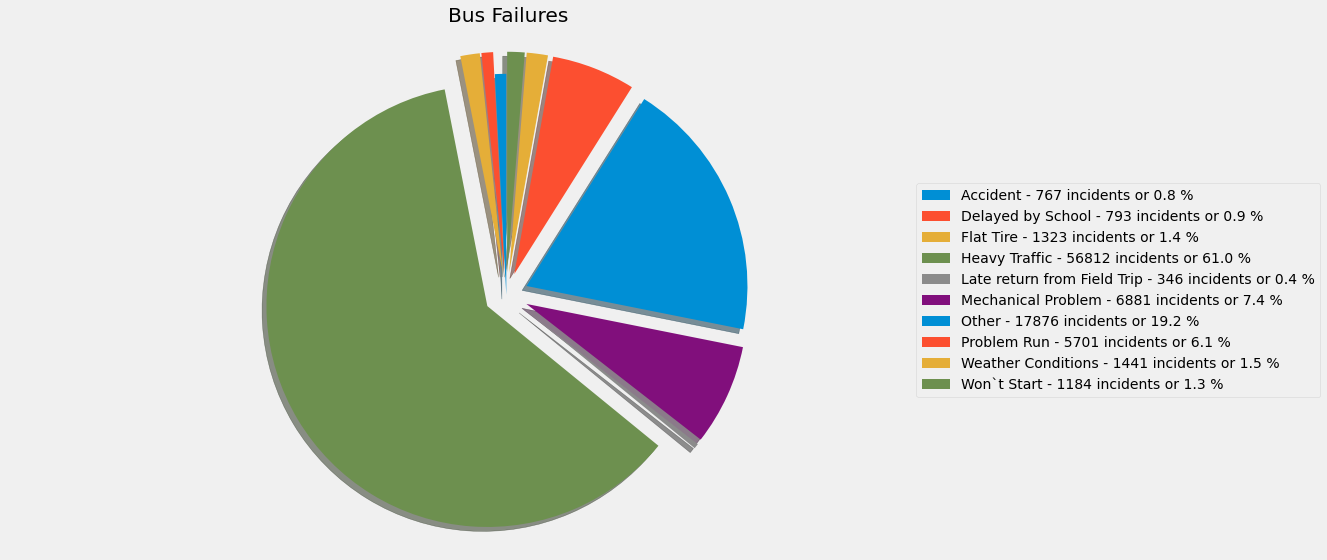

time: 1.9 s (started: 2022-11-02 15:22:06 -04:00)


In [86]:
# Reason for school bus delays

data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).count()
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
days_to_drop = data_tmp[data_tmp['School_Year'] < num_delays_threshold].index

data_tmp = data.set_index([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
data_tmp = data_tmp.drop(days_to_drop).sort_index()

# Make data_tmp post covid
data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2021)]
data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2022) |
                    (data_tmp.index.get_level_values(1) > 8)]

#Subset to past 2 months
# data_tmp = data_tmp[(data_tmp.index.get_level_values(0) == 2022 ) & 
#                     (data_tmp.index.get_level_values(1).isin([9, 10]))]

num = data_tmp.groupby('Reason').count()['School_Year']
reason = num.index

percent = []
for i in num:
    percent.append(float(i)*100/float(np.array(num).sum()))

labels = ['{0} - {1} incidents or {2:1.1f} %'.format(i,j,k) for i,j,k in zip(reason, num, percent)]

explode = [0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
    
# Plot
plt.rcParams["figure.figsize"] = [16,9]

patches, texts = plt.pie(num, shadow=True, explode = explode, startangle=90)

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5))
plt.title("Bus Failures")                  
plt.axis('equal');

In [87]:
# Reasons for delays. Here we can show that Heavy Traffic accounted for 73.8% of delays (above)
# And average delay time due to heavy traffic delays (below)


#Length of delays by reason
data_tmp.groupby('Reason').mean()['delay_time']

Reason
Accident                       42.101043
Delayed by School              26.233291
Flat Tire                      21.137944
Heavy Traffic                  34.892752
Late return from Field Trip    33.864162
Mechanical Problem             24.581965
Other                          37.006909
Problem Run                    45.958516
Weather Conditions             33.276544
Won`t Start                    15.863598
Name: delay_time, dtype: float64

time: 12.1 ms (started: 2022-11-02 15:22:08 -04:00)


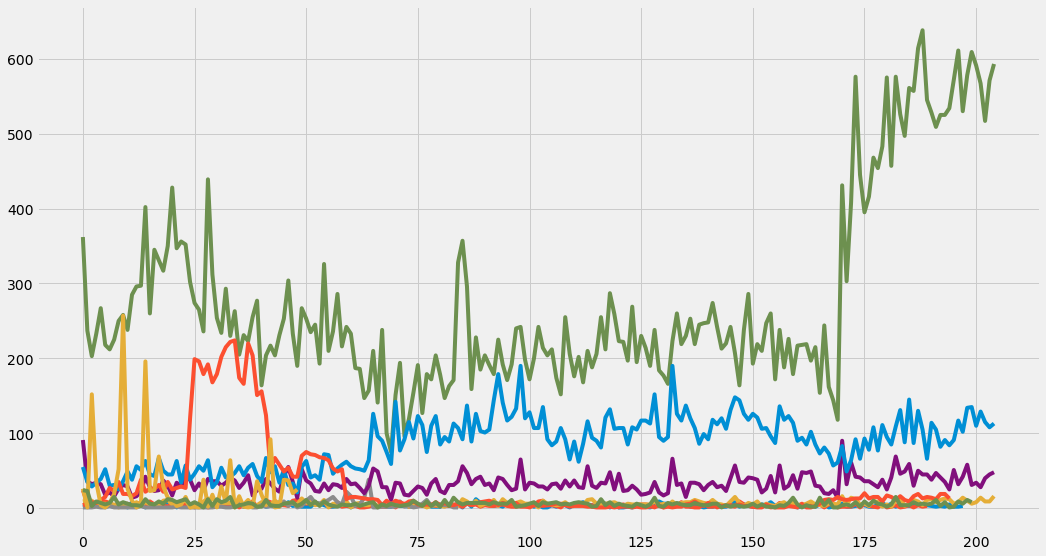

time: 361 ms (started: 2022-11-02 18:07:39 -04:00)


In [136]:
# Reasons for delays over time

reasons_for_delays = data_tmp.reset_index().groupby(['Reason', 'Year', 'Month', 'Day']).count()['School_Year'].reset_index()

for i in reasons_for_delays['Reason'].unique():
    plt.plot(reasons_for_delays[reasons_for_delays['Reason'] == i]['School_Year'].reset_index()['School_Year'])